# OGH2023
In this notebook, we will answer some questions raised at OGH2023

## Machine learning (hackathon)

In [1]:
using Rasters, ArchGDAL, Plots, DataFrames

In [16]:
folder = "/Users/evetion/Downloads/ogh2023/Landast"
tifs = filter(endswith("TIF"), readdir(folder, join=true))

b8, stack... = tifs  # split into 1, many

highres = Raster(b8)
bands = map(x->first(splitext(x))[end-1:end], stack)  # map last 2 chars of filenames
rs = RasterStack(stack; name=bands)

RasterStack with dimensions: 
  X Projected{Float64} LinRange{Float64}(246375.0, 307635.0, 2043) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected{Float64} LinRange{Float64}(5.948e6, 5.831e6, 3901) ReverseOrdered Regular Intervals crs: WellKnownText
and 7 layers:
  :B1 UInt16 dims: X, Y (2043×3901)
  :B2 UInt16 dims: X, Y (2043×3901)
  :B3 UInt16 dims: X, Y (2043×3901)
  :B4 UInt16 dims: X, Y (2043×3901)
  :B5 UInt16 dims: X, Y (2043×3901)
  :B6 UInt16 dims: X, Y (2043×3901)
  :B7 UInt16 dims: X, Y (2043×3901)


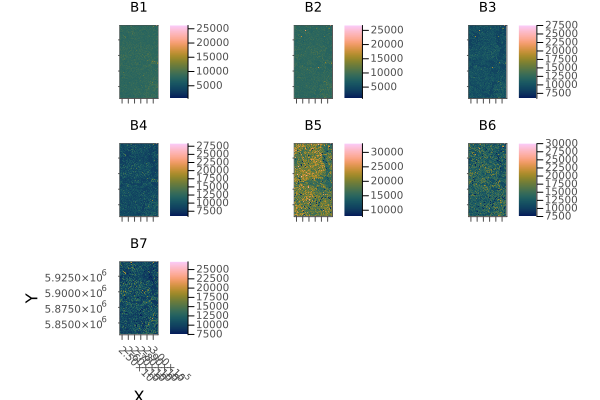

In [3]:
plot(rs)

In [19]:
@time ndvi = (rs[:B5] - rs[:B4]) ./ (rs[:B5] + rs[:B4])
# note that there is also RemoteSensingToolbox.jl, a very recent package

  0.114280 seconds (39.82 k allocations: 93.562 MiB, 91.28% compilation time: 100% of which was recompilation)


2043×3901 Raster{Float64,2} with dimensions: 
  X Projected{Float64} LinRange{Float64}(246375.0, 307635.0, 2043) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected{Float64} LinRange{Float64}(5.948e6, 5.831e6, 3901) ReverseOrdered Regular Intervals crs: WellKnownText
extent: Extent(X = (246375.0, 307665.0), Y = (5.830995e6, 5.948025e6))missingval: 0x0000crs: PROJCS["WGS 84 / UTM zone 34N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32634"]]
parent:
           5.948e6

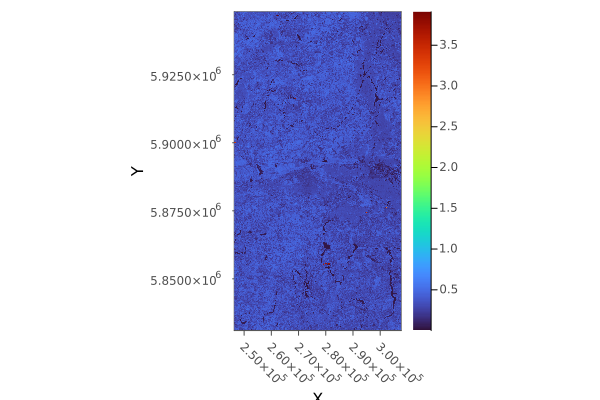

In [20]:
plot(ndvi, c=:turbo)

We also need to resample the high-res band to a lower resolution or vice-versa.

In [14]:
lowres = resample(highres; to=rs)  # this actually calls gdalwarp

2043×3901 Raster{UInt16,2} with dimensions: 
  X Projected{Float64} LinRange{Float64}(246375.0, 307635.0, 2043) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected{Float64} LinRange{Float64}(5.948e6, 5.831e6, 3901) ReverseOrdered Regular Intervals crs: WellKnownText
and reference dimensions: 
  Band Categorical{Int64} 1:1 ForwardOrdered
extent: Extent(X = (246375.0, 307665.0), Y = (5.830995e6, 5.948025e6))missingval: 0x0000crs: PROJCS["WGS 84 / UTM zone 34N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS[

In [7]:
combined = RasterStack(rs..., lowres)

RasterStack with dimensions: 
  X Projected{Float64} LinRange{Float64}(246375.0, 307635.0, 2043) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected{Float64} LinRange{Float64}(5.948e6, 5.831e6, 3901) ReverseOrdered Regular Intervals crs: WellKnownText
and 8 layers:
  :B1     UInt16 dims: X, Y (2043×3901)
  :B2     UInt16 dims: X, Y (2043×3901)
  :B3     UInt16 dims: X, Y (2043×3901)
  :B4     UInt16 dims: X, Y (2043×3901)
  :B5     UInt16 dims: X, Y (2043×3901)
  :B6     UInt16 dims: X, Y (2043×3901)
  :B7     UInt16 dims: X, Y (2043×3901)
  :layer8 UInt16 dims: X, Y (2043×3901)


In [24]:
df = DataFrame(combined)
df.geometry .= zip(df.X, df.Y)
df

7969743×11 DataFrame
     Row │ X         Y        B1      B2      B3      B4      B5      B6       ⋯
         │ Float64   Float64  UInt16  UInt16  UInt16  UInt16  UInt16  UInt16   ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │ 246375.0  5.948e6    8452    9076   10847   11123   21946   15626   ⋯
       2 │ 246405.0  5.948e6    8238    8885   10607   10633   21785   14566
       3 │ 246435.0  5.948e6    8234    8887   10592   10933   20806   15724
       4 │ 246465.0  5.948e6    8287    8942   10651   10991   20387   16130
       5 │ 246495.0  5.948e6    8433    9038   10766   10816   20719   16408   ⋯
       6 │ 246525.0  5.948e6    8307    8917   10626   10725   20632   16754
       7 │ 246555.0  5.948e6    8308    8951   10622   10550   21335   16187
       8 │ 246585.0  5.948e6    8460    9263   11024   10946   21917   16312
       9 │ 246615.0  5.948e6    8450    9260   11198   11218   22332   16568   ⋯
      10 │ 246645.0  5.948e6    8918    9779   11503   11274   22517   16370
      11 │ 246675.0  5.948e6    9098    9676   11306   11045   22626   16117
    ⋮    │    ⋮         ⋮       ⋮       ⋮       ⋮       ⋮       ⋮       ⋮      ⋱
 7969734 │ 307365.0  5.831e6    7814    8168    9086    8517   22667   12740
 7969735 │ 307395.0  5.831e6    7853    8163    9051    8523   22571   12658   ⋯
 7969736 │ 307425.0  5.831e6    7862    8163    9035    8514   22461   12677
 7969737 │ 307455.0  5.831e6    7786    8127    8996    8477   21888   12593
 7969738 │ 307485.0  5.831e6    7823    8154    9059    8514   21469   12489
 7969739 │ 307515.0  5.831e6    7911    8203    9144    8580   21952   12750   ⋯
 7969740 │ 307545.0  5.831e6    7966    8280    9171    8632   23119   13431
 7969741 │ 307575.0  5.831e6    7950    8274    9242    8606   23419   13364
 7969742 │ 307605.0  5.831e6    7845    8229    9217    8568   24159   13775
 7969743 │ 307635.0  5.831e6    7861    8168    9133    8490   25428   13855   ⋯
                                              3 columns and 7969722 rows omitted

In [25]:
using GeoDataFrames
GeoDataFrames.write("test.gpkg", df[1:1000, :])  # GDAL is very slow at saving such large files

"test.gpkg"

Now that the data is in a table format, we can use things from the MLJ.jl ecosystem. Please check it's documentation here. A great tutorial using [MLJ](https://alan-turing-institute.github.io/MLJ.jl/dev/list_of_supported_models/#model_list) and spatial data can be found in the GeoStats.jl ecosystem at https://juliaearth.github.io/GeoStats.jl/stable/quickstart.html#Defining-problems. MLJ wraps *many* ML models, including all those from scikitlearn.

I'll be using this approach to try to solve the hackathon(s) and will provide these scripts in my repository/mattermost later this week.

## R <-> Julia
There was a poll option about the Julia and R interaction. From the R side, there's [JuliaCall](https://cran.r-project.org/web/packages/JuliaCall/readme/README.html) to call Julia.

However, I'm not an R person, so I will show you the other way around. This assumes you have R installed. I'll be using RCall, which is documented [here]( https://juliainterop.github.io/RCall.jl/stable/gettingstarted/).

In [11]:
using Pkg
Pkg.add("RCall")
using RCall

   Resolving package versions...
  No Changes to `~/code/Project.toml`
  No Changes to `~/code/Manifest.toml`


In [12]:
@rlibrary boot

In [13]:
city = rcopy(R"boot::city")

10×2 DataFrame
 Row │ u        x       
     │ Float64  Float64 
─────┼──────────────────
   1 │   138.0    143.0
   2 │    93.0    104.0
   3 │    61.0     69.0
   4 │   179.0    260.0
   5 │    48.0     75.0
   6 │    37.0     63.0
   7 │    29.0     50.0
   8 │    23.0     48.0
   9 │    30.0    111.0
  10 │     2.0     50.0

But the R mode $ is not working in Jupyter, so let's switch to a terminal.